In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import scipy.linalg as la
import scipy.stats as sts
from matplotlib.pyplot import *

import jax
import jax.numpy as jnp

from copy import copy

In [2]:
%matplotlib widget

I0000 00:00:1702511353.728110       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0, 0.5, 'Cross Section ($\\sigma$)')

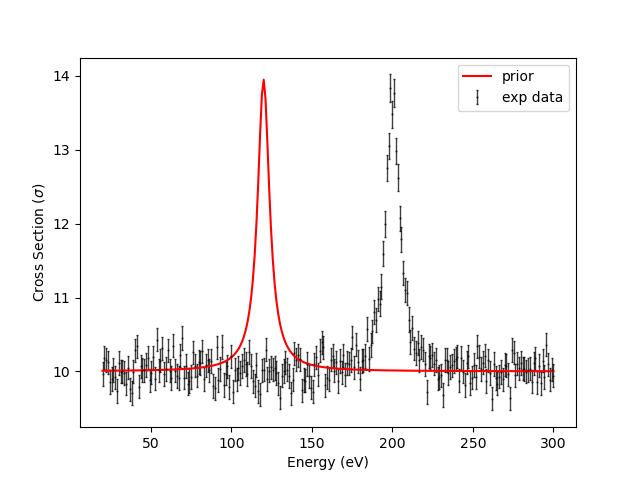

In [3]:
# Define the function using JAX NumPy
def Breit_Wigner(theta, E):
    Elam, Gg, Gn = jnp.split(theta, 3)
    xs = jnp.zeros(len(E))
    for iE, iGg, iGn in zip(Elam, Gg, Gn):
        xs += iGg * iGn / ((E - iE) ** 2 + (iGg + iGn) ** 2 / 4)
    return xs*10 + 10


idat = 250
E = np.linspace(20,300,idat)


true_theta = np.array([ 200.0,  
                        8.0,    
                        1.0,    ])
true_mod = Breit_Wigner(true_theta, E)
std = np.sqrt(true_mod)/20
sample_data = sts.norm.rvs(loc=true_mod, scale=std)
sample_cov = np.diag(np.ones(len(sample_data))*std**2)

prior_theta = np.array([120.0,  
                        8.0,    
                        1.0,    ])
prior_mod = Breit_Wigner(prior_theta,E)

figure()
# plot(x, lorentz(x, 50, 10))
errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(),
          alpha=0.75, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='exp data')
# plot(E, true_mod, label='true', color='b')
plot(E, prior_mod, label='prior', color='r')

legend()
xlabel('Energy (eV)')
ylabel(r'Cross Section ($\sigma$)')

In [4]:
G = jax.jacobian(Breit_Wigner, argnums=0)(prior_theta, E)
y_pred = Breit_Wigner(prior_theta, E)
gradient1 = -2 * (G.T@la.inv(sample_cov)@(sample_data-y_pred)) 
gradient2 = -2 * ((sample_data-y_pred).T@la.inv(sample_cov)@G) 
print(gradient1)
print(gradient2)

[ -29.744032 -330.20874  6547.301   ]
[ -29.744032 -330.2087   6547.301   ]


In [5]:
Elam = np.linspace(min(E),max(E), 30)
Gn = np.linspace(0.0, 15.0, 30)

# gradient_E = np.zeros([len(Elam), len(Gn)])
chi2_map = np.zeros([len(Elam), len(Gn)])


for ie, e in enumerate(Elam):
    for ig, g in enumerate(Gn):

        prior_theta = np.array([e,  
                                g,    
                                1.0,    ])
        # Compute predictions
        y_pred = Breit_Wigner(prior_theta, E)
        chi2 = (sample_data-y_pred).T @ la.inv(sample_cov) @ (sample_data-y_pred)

        # Compute the gradient of the mean squared error with L1 penalty
        # G = jax.jacobian(Breit_Wigner, argnums=0)(prior_theta, E)
        # Elam, Gg, Gn = jnp.split(prior_theta, 3)
        # grad = -2 * (G.T@la.inv(sample_cov)@(sample_data-y_pred))

        chi2_map[ie, ig] = chi2

chi2_map_norm = chi2_map/len(E)

Text(0.5, 0, '$\\chi^2$/DOF')

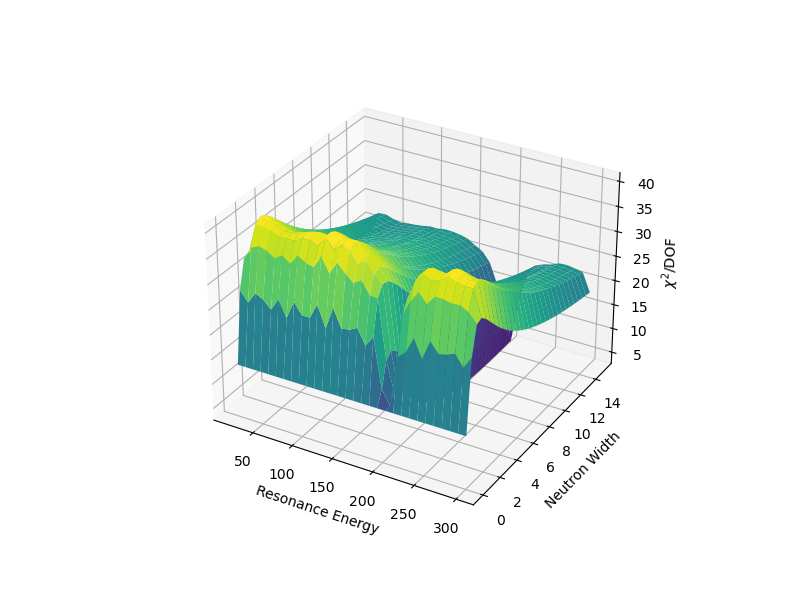

In [6]:
g, e = np.meshgrid(Gn, Elam)


fig =figure(figsize=(8,6))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=e, Y=g, Z=chi2_map_norm, cmap = 'viridis')
ax.set_xlabel('Resonance Energy')
ax.set_ylabel('Neutron Width')
ax.set_zlabel(r'$\chi^2$/DOF')

# Show the plot
# plt.show()

In [7]:
chi2_map_norm.shape

(30, 30)

Text(0.5, 1.0, 'Simplest default with labels')

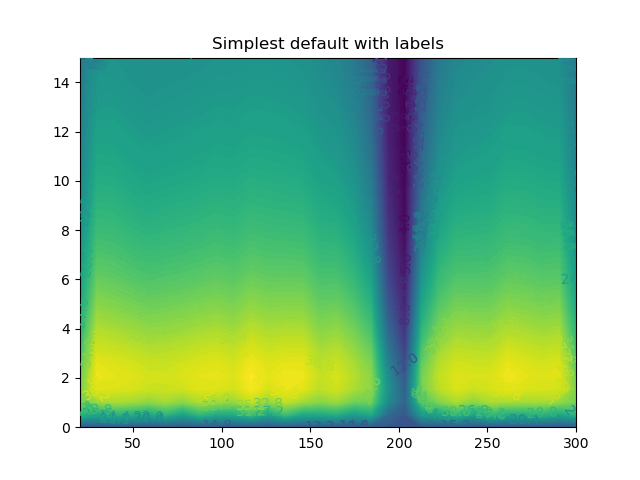

In [8]:
# figure()
# ax = fig.add_subplot(111)
# CS = ax.contour([e, g,], chi2_map_norm)
fig, ax = subplots()
CS = ax.contourf(e, g, chi2_map_norm, levels=100)
ax.clabel(CS, inline=False, fontsize=10) #
ax.set_title('Simplest default with labels')


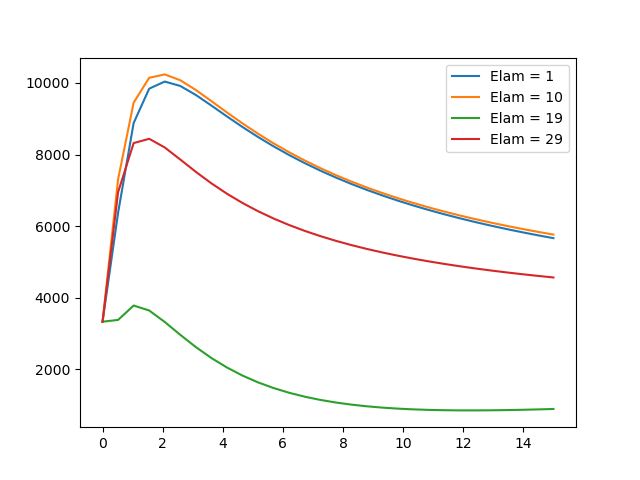

In [9]:
figure()

for iE in [1, 10, 19, 29]:
    plot(Gn, chi2_map[iE, :], label=f'Elam = {iE}')
legend()

Text(0.5, 0, 'Resonance Energy')

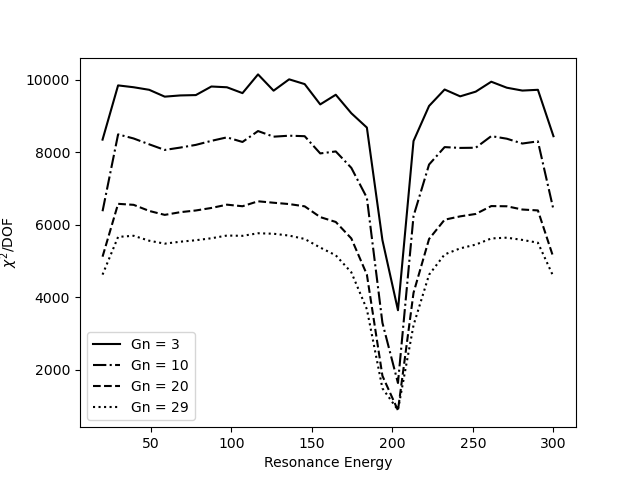

In [10]:
markers = ['solid', 'dashdot', 'dashed','dotted']
figure()
for i,ign in enumerate([3,10,20,29]):
    plot(Elam, chi2_map[:,ign], label =f'Gn = {ign}', linestyle=markers[i], color ='k');

legend()
ylabel(r'$\chi^2$/DOF')
xlabel('Resonance Energy')

In [11]:
import numpy as np

def gls_regression(X, y, W):
    """
    Generalized Least Squares (GLS) regression.

    Parameters:
    - X: Design matrix
    - y: Response variable
    - W: Weight matrix (inverse of the covariance matrix of errors)

    Returns:
    - Beta: GLS regression coefficients
    """
    XTWX_inv = np.linalg.inv(X.T @ W @ X)
    Beta = XTWX_inv @ X.T @ W @ y
    return Beta

# Example usage:
# Assuming X, y, and W are defined elsewhere
# For example, replace these lines with your actual data
X = np.random.rand(100, 3)
y = np.random.rand(100)
W = np.linalg.inv(np.diag(np.ones(100)))  # Identity matrix as an example

beta_gls = gls_regression(X, y, W)
print("GLS Coefficients:", beta_gls)


GLS Coefficients: [0.21462906 0.35028088 0.35328555]


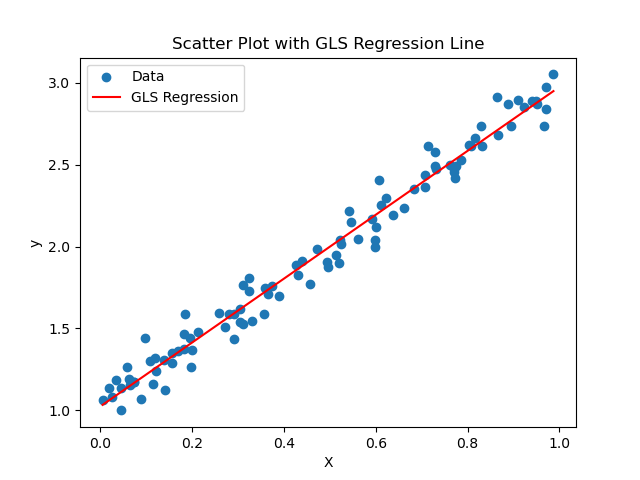

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * X.squeeze() + 1 + 0.1 * np.random.randn(100)  # Example linear relationship with noise

# Design matrix
X_design = np.column_stack((np.ones_like(X), X))

# Weight matrix (assuming homoscedastic errors for simplicity)
W = np.linalg.inv(np.eye(len(X)))

# GLS regression
beta_gls = np.linalg.inv(X_design.T @ W @ X_design) @ X_design.T @ W @ y

figure()
# Scatter plot of the data
scatter(X, y, label='Data')

# Plot the GLS regression line
x_range = np.linspace(X.min(), X.max(), 100)
X_range_design = np.column_stack((np.ones_like(x_range), x_range))
y_gls = X_range_design @ beta_gls
plot(x_range, y_gls, color='red', label='GLS Regression')

xlabel('X')
ylabel('y')
legend()
title('Scatter Plot with GLS Regression Line')
show()
